In [10]:
using HDF5, ANTSUNData, PyPlot, FlavellBase, PyCall, Statistics,
    EncoderModelGen, GenAnalysis, AnalysisBase, FlavellConstants, ProgressMeter, StatsBase,
    MultivariateStats, LinearAlgebra, ClusterValidityIndices, Clustering
zstd = FlavellBase.standardize

standardize (generic function with 1 method)

In [11]:
rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out");
    ax = gca(); ax[:xaxis][:tick_bottom]();
    ax[:yaxis][:tick_left]();
    ax[:spines]["top"]["set_visible"](false);
    ax[:spines]["right"]["set_visible"](false););

In [12]:
path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft1/figure1"

"/data1/prj_kfc/figure/manuscript/cell_draft1/figure1"

In [13]:
path_h5_enc = "/data1/jungsoo/2022-10-14-baseline-enc.h5"

"/data1/jungsoo/2022-10-14-baseline-enc.h5"

In [14]:
list_uid_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
list_uid_baseline_continuous = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];

list_uid = sort(unique(vcat(list_uid_baseline_merged, list_uid_baseline_continuous)))

14-element Vector{String}:
 "2021-05-26-07"
 "2021-06-11-01"
 "2021-08-04-06"
 "2021-08-17-01"
 "2021-08-18-01"
 "2021-09-22-05"
 "2021-10-26-01"
 "2021-11-12-01"
 "2021-11-12-05"
 "2022-01-09-01"
 "2022-01-17-01"
 "2022-04-05-01"
 "2022-04-12-04"
 "2022-04-14-04"

In [15]:
σ_GFP = 0.07179528884124053

0.07179528884124053

In [16]:
1/(1-0.8)

5.000000000000001

In [8]:
function find_neuron_snr(trace_array, θ, σ_GFP)
    snr_factor = 1 / (1-θ)
    findall(std(trace_array, dims=2)[:] .> (snr_factor * σ_GFP))
end

find_neuron_snr (generic function with 1 method)

In [414]:
list_array_var_explained = []
list_overall_var_explained = []
let
    @showprogress for (idx_uid, data_uid) = enumerate(list_uid)
        path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
        data_dict =  import_data(path_data)
        dict_fit = h5read(path_h5_enc, data_uid);

        trace_original = data_dict["trace_original"]

        X = trace_original
        n_neuron = size(X, 1)
        trace_pca = MultivariateStats.fit(PCA, X,
            maxoutdim=n_neuron, pratio=1)
        
        Yt = predict(trace_pca, X)
        pca_loadings = loadings(trace_pca)
        pca_projection = projection(trace_pca)
        list_X_mean = trace_pca.mean

        n_neuron, n_pc = size(pca_projection)
        array_var_explained = zeros(n_neuron, n_pc)
        for idx_neuron = 1:n_neuron
            for n_pc = 1:n_pc
                x_original = X[idx_neuron,:]
                idx_order_projection = sortperm(abs.(pca_loadings[idx_neuron,:]), rev=true)
                x_pred = (pca_projection[idx_neuron,idx_order_projection[1:n_pc]]' * Yt[idx_order_projection[1:n_pc],:])[:] .+ list_X_mean[idx_neuron]

                r2_pca = 1 - sum((x_original .- x_pred) .^ 2) / sum((x_original .- mean(x_original)) .^ 2)

                array_var_explained[idx_neuron, n_pc] = r2_pca
            end
        end
        push!(list_array_var_explained, array_var_explained)
        push!(list_overall_var_explained, (principalvars(trace_pca), tprincipalvar(trace_pca), var(trace_pca)))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


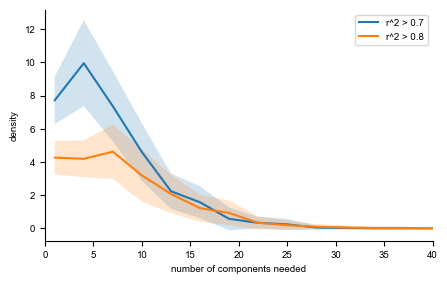

In [454]:
let
    figure(figsize=(5,3))
    for (i_θ, θ) = enumerate([0.7, 0.8])
        rg_hist = 1:3:50
        list_hist_weights = []
        for idx_uid = 1:length(list_uid)
            data_uid = list_uid[idx_uid]
            path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
            data_dict =  import_data(path_data)
            trace_original = data_dict["trace_original"]
            X = trace_original ./ mean(trace_original, dims=2)

            idx_neuron_snr = find_neuron_snr(X, θ, σ_GFP)
            idx_neuron_use = idx_neuron_snr
            
            array_ = list_array_var_explained[idx_uid]
            n_neuron = size(array_, 2)
                
            data_ = [findfirst(array_[idx_neuron,:] .> θ) for idx_neuron = idx_neuron_use]

            hist_fit = fit(Histogram, data_, rg_hist)
            hist_fit = normalize(hist_fit, mode=:density)
            push!(list_hist_weights, hist_fit.weights)
        end

        hist_array = hcat(list_hist_weights...)'
        n_sample = size(hist_array, 1)
        u = meanprj(hist_array, dims=1)
        s = dropdims(std(hist_array, dims=1), dims=1)# / sqrt(n_sample)


        y1 = u .- s
        y2 = u
        y3 = u .+ s

        plot(rg_hist[1:end-1],y2, label="r^2 > $θ")
        fill_between(rg_hist[1:end-1], y1, y3, alpha=0.2, linewidth=0)
        
        # overall variance
        list_n_pc = []
        for idx_uid = 1:length(list_uid)
            tvar = list_overall_var_explained[idx_uid][3]
            list_var = list_overall_var_explained[idx_uid][1]

            push!(list_n_pc, findfirst(cumsum(list_var ./ tvar) .> θ))
        end

        # axvline(mean(list_n_pc), color="C$(i_θ-1)")
        # println(mean(list_n_pc))
    end
    # axvline(5, color="k")
    # axvline(10, color="k")
    legend()
    xlabel("number of components needed")
    ylabel("density")
    xlim(0,40)
    # ylim(0,10)
    fix_plot()
end

8.142857142857142


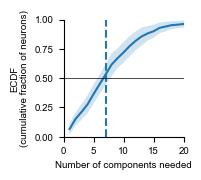

In [457]:
let
    figure(figsize=(2,1.75))
    for (i_θ, θ) = enumerate([0.75])
        rg_hist = 1:1:40
        list_hist_weights = []
        for idx_uid = 1:length(list_uid)
            data_uid = list_uid[idx_uid]
            path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
            data_dict =  import_data(path_data)
            trace_original = data_dict["trace_original"]
            X = trace_original ./ mean(trace_original, dims=2)

            idx_neuron_snr = find_neuron_snr(X, θ, σ_GFP)
            idx_neuron_use = idx_neuron_snr

            array_ = list_array_var_explained[idx_uid]
            n_neuron = size(array_, 2)

            data_ = [findfirst(array_[idx_neuron,:] .> θ) for idx_neuron = idx_neuron_use]

            # hist_fit = fit(Histogram, data_, rg_hist)
            # hist_fit = normalize(hist_fit, mode=:density)
            ecdf_ = ecdf(data_)
            push!(list_hist_weights, ecdf_.(rg_hist))
        end

        hist_array = hcat(list_hist_weights...)'
        n_sample = size(hist_array, 1)
        u = meanprj(hist_array, dims=1)
        s = dropdims(std(hist_array, dims=1), dims=1)# / sqrt(n_sample)


        y1 = u .- s
        y2 = u
        y3 = u .+ s

        plot(rg_hist,y2, label="r^2 > $θ")
        fill_between(rg_hist, y1, y3, alpha=0.2, linewidth=0)
        
        # overall variance
        list_n_pc = []
        for idx_uid = 1:length(list_uid)
            tvar = list_overall_var_explained[idx_uid][3]
            list_var = list_overall_var_explained[idx_uid][1]

            push!(list_n_pc, findfirst(cumsum(list_var ./ tvar) .> θ))
        end

        # axvline(mean(list_n_pc), color="C$(i_θ-1)")
        println(mean(list_n_pc))
        
        idx_ = findfirst(y2 .> 0.5)
        axvline(rg_hist[idx_], color="C$(i_θ-1)", linestyle="--")
        # println(rg_hist[idx_])
    end
    # legend()
    xlabel("Number of components needed")
    ylabel("ECDF\n(cumulative fraction of neurons)")
    xlim(0,20)
    ylim(0,1)
    yticks(0:0.25:1)
    axhline(0.5, color="k", linewidth=0.5)
    fix_plot()
    tight_layout()
    path_fig = "/data1/prj_kfc/figure/manuscript/cell_draft1/figure3/pca_num_comp_ecdf.pdf"
    savefig(path_fig)
end

## Cluster

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


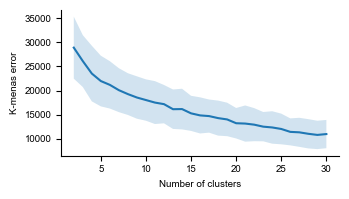

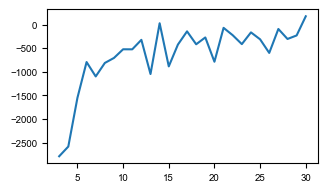

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f145a3a15b0>

In [74]:
let
    list_cost_all = []
    rg_n_clust = 2:30
    @showprogress for idx_uid = 1:length(list_uid)
        data_uid = list_uid[idx_uid]
        path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
        data_dict =  import_data(path_data)
        dict_fit = h5read(path_h5_enc, data_uid);

        trace_original = data_dict["trace_original"]

        X = Array(trace_original')
        X = Array((trace_original ./ mean(trace_original, dims=2))')
        list_cost = []
        for n_clust = rg_n_clust
            kmns_res = kmeans(X, n_clust)
            push!(list_cost, kmns_res.totalcost)
        end
        push!(list_cost_all, list_cost)
    end
    
    data_ = hcat(list_cost_all...)'
    
    n_sample = size(data_, 1)
    u = meanprj(data_, dims=1)
    s = dropdims(std(data_, dims=1), dims=1)# / sqrt(n_sample)

    y1 = u .- s
    y2 = u
    y3 = u .+ s

    figure(figsize=(3.5,2))
    plot(rg_n_clust,y2)
    fill_between(rg_n_clust, y1, y3, alpha=0.2, linewidth=0)
    xlabel("Number of clusters")
    ylabel("K-menas error")
    # ylim(10000,50000)
    fix_plot()
    tight_layout()

    figure(figsize=(3.5,2))
    plot(rg_n_clust[2:end], diff(y2))
    # path_fig = "/data1/prj_kfc/figure/manuscript/cell_draft1/figure3/kmeans_error.pdf"
    # savefig(path_fig)
end

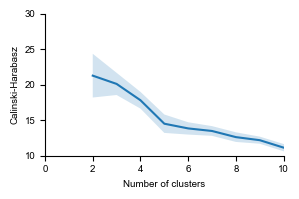

In [349]:
let
    list_cost_all = []
    rg_n_clust = 2:30

    for idx_uid = 1:length(list_uid)
        data_uid = list_uid[idx_uid]
        path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
        data_dict =  import_data(path_data)
        dict_fit = h5read(path_h5_enc, data_uid);

        trace_original = data_dict["trace_original"]

        idx_neuron_c = unique(vcat([dict_fit["categorization"]["$i"]["all"] for i = 1:2]...))

        # X = Array(trace_original')
        X = Array((trace_original[idx_neuron_c,:] ./ mean(trace_original[idx_neuron_c,:], dims=2))')
        # X = Array(data_dict["trace_array"][idx_neuron_c,:]')
        
        list_cvi = []
        for n_clust = rg_n_clust
            kmns_res = kmeans(X, n_clust)
            cvi = CH()
            data = Array(X')
            labels = kmns_res.assignments
            
            push!(list_cvi, py_sklearn_metrics.calinski_harabasz_score(Array(X'), labels))
            # push!(list_cvi, get_cvi!(cvi, data, labels))
        end
        push!(list_cost_all, list_cvi)
    end
    
    data_ = hcat(list_cost_all...)'
    
    n_sample = size(data_, 1)
    u = meanprj(data_, dims=1)
    s = dropdims(std(data_, dims=1), dims=1) / sqrt(n_sample)

    y1 = u .- s
    y2 = u
    y3 = u .+ s

    figure(figsize=(3,2))
    plot(rg_n_clust,y2)
    fill_between(rg_n_clust, y1, y3, alpha=0.2, linewidth=0)
    xlabel("Number of clusters")
    ylabel("Calinski-Harabasz")

    xlim(0,10)
    ylim(10,30)
    
    fix_plot()
    tight_layout()

    savefig("/data1/prj_kfc/figure/manuscript/cell_draft1/figureS4/cluster_CH.pdf")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


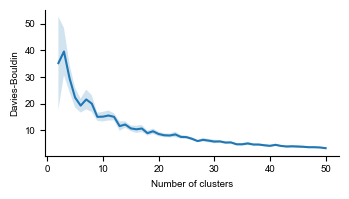

In [198]:
let
    list_cost_all = []
    rg_n_clust = 2:50

    @showprogress for idx_uid = 1:length(list_uid)
        data_uid = list_uid[idx_uid]
        path_data = "/data1/jungsoo/data/processed_h5/$(data_uid)-data.h5"
        data_dict =  import_data(path_data)
        dict_fit = h5read(path_h5_enc, data_uid);

        trace_original = data_dict["trace_original"]
        
        idx_neuron_c = unique(vcat([dict_fit["categorization"]["$i"]["all"] for i = 1:2]...))

        # X = Array(trace_original')
        X = Array((trace_original[idx_neuron_c,:] ./ mean(trace_original[idx_neuron_c,:], dims=2))')

        list_cvi = []
        for n_clust = rg_n_clust
            kmns_res = kmeans(X, n_clust)

            cvi = DB()
            data = X
            labels = kmns_res.assignments
            push!(list_cvi, get_cvi!(cvi, Array(data'), labels))
        end
        push!(list_cost_all, list_cvi)
    end
    
    data_ = hcat(list_cost_all...)'
    
    n_sample = size(data_, 1)
    u = meanprj(data_, dims=1)
    s = dropdims(std(data_, dims=1), dims=1) / sqrt(n_sample)

    y1 = u .- s
    y2 = u
    y3 = u .+ s

    figure(figsize=(3.5,2))
    plot(rg_n_clust,y2)
    fill_between(rg_n_clust, y1, y3, alpha=0.2, linewidth=0)
    xlabel("Number of clusters")
    ylabel("Davies-Bouldin")
    # xlim(0,10)
    # ylim(10000,50000)
    fix_plot()
    tight_layout()

end